In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn 

In [3]:
data = pd.read_csv("training_dataset_enc.csv", parse_dates=[2,5,6,7])

In [4]:
for i in range(len(data)):
    if data.at[i, 'DATUM_ZATVARANJA'] +  pd.DateOffset(days=10)  <  data.at[i, 'PLANIRANI_DATUM_ZATVARANJA']:
        data.at[i, 'PRIJEVREMENI_RASKID'] = 'Y'
    else:
        data.at[i, 'PRIJEVREMENI_RASKID'] = 'N'

In [5]:
data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

# Čišćenje podataka  - prva faza
Uklanjamo retke koji su potvrđena greška.
 - planirani datum zatvaranja < datum otvaranja
 - ugovoreni iznos = 0
 - retci bez planiranog datuma zatvaranja
 
Rezultat spremamo u  *prva_faza*.

In [6]:
prva_faza = data.drop(data[data['DATUM_OTVARANJA'] > data['PLANIRANI_DATUM_ZATVARANJA']].index)

In [7]:
prva_faza = prva_faza.drop(prva_faza[prva_faza['UGOVORENI_IZNOS'] == 0].index)

In [8]:
prva_faza = prva_faza.loc[pd.isnull(prva_faza['PLANIRANI_DATUM_ZATVARANJA']) == False, :]

In [9]:
#prva_faza.to_csv('prva_faza.csv')

# Čišćenje podataka - druga faza

 - ostavljamo za svaki ugovor samo jedan izvještaj i to onaj u kojem se prvi put spominje datum zatvaranja ( *druga_faza* )
 
 
Pažnja na rubne slučajeve, cijeli skup podataka dijelimo u 4 skupine :
- zatvoreni ugovori koji su prijevremno otplaćeni (Y)
- zatvoreni ugovori koji nisu prijevremeni otplaćeni (N)
- ugovori čiji je datum planiranog zatvaranja prošao, ali nisu otplaćeni (N)
- ugovori čiji datum planiranog zatvaranja nije prosao i nisu zatvoreni (zapravo ne znamo gdje spadaju)

In [12]:
#prva_faza = pd.read_csv("prva_faza.csv", parse_dates=[1,4,5,6])

In [11]:
otplaceni_ugovori = prva_faza.loc[pd.isnull(prva_faza['DATUM_ZATVARANJA']) == False,:]\
            .sort_values(['OZNAKA_PARTIJE', 'DATUM_IZVJESTAVANJA'])

In [12]:
otplaceni_ugovori = otplaceni_ugovori.groupby('OZNAKA_PARTIJE').head(1)

In [13]:
svi_ugovori = prva_faza.sort_values(['OZNAKA_PARTIJE', 'DATUM_IZVJESTAVANJA'])
svi_ugovori = svi_ugovori.groupby('OZNAKA_PARTIJE')

neisplaceni_ugovori = svi_ugovori.filter(lambda x: all(pd.isnull(x['DATUM_ZATVARANJA']) == True))

In [14]:
neisplaceni_ugovori = neisplaceni_ugovori.groupby('OZNAKA_PARTIJE').tail(1)

In [15]:
neisplaceni = neisplaceni_ugovori.loc[neisplaceni_ugovori['PLANIRANI_DATUM_ZATVARANJA'] < neisplaceni_ugovori['DATUM_IZVJESTAVANJA'],:]

In [16]:
druga_faza = pd.concat([otplaceni_ugovori, neisplaceni])

In [17]:
#druga_faza.to_csv('druga_faza.csv')

# Dodavanje featurea

In [3]:
druga_faza = pd.read_csv('druga_faza.csv', parse_dates=[1,4,5,6])

**NADVRSTA** - Nadvrsta klijenata. Podijela na fizicke i pravne osobe.

In [4]:
nadvrsta_dict = {1410:0,1550:0,1610:0,\
                 1420:1, 1430:1, 1120:1, 1510:1, 1110:1, 1320:1, 1330:1, 1350:1,1210:1, 1310:1}
druga_faza['NADVRSTA'] = druga_faza['VRSTA_KLIJENTA']
druga_faza['NADVRSTA'] = druga_faza['NADVRSTA'].map(nadvrsta_dict)

**STAROST** - Popunjavanje nepoznatih vrijednosti godina srednjim vrijednostima za fizicke i pravne osobe.

In [5]:
import operator

druga_faza['STAROST'] = druga_faza['STAROST'].astype('float')
for i in range(len(druga_faza)):
    if druga_faza.at[i,'STAROST'] < 0 or druga_faza.at[i,'STAROST'] >= 900 :
            druga_faza.at[i,'STAROST'] = np.nan


**MJESECI** - Broj procijenjenih mjeseci potreban za otplatu kredita

In [6]:
druga_faza['MJESECI'] = 12*(pd.DatetimeIndex(druga_faza['PLANIRANI_DATUM_ZATVARANJA']).year\
                    - pd.DatetimeIndex(druga_faza['DATUM_OTVARANJA']).year)\
                    + (pd.DatetimeIndex(druga_faza['PLANIRANI_DATUM_ZATVARANJA']).month\
                    - pd.DatetimeIndex(druga_faza['DATUM_OTVARANJA']).month)

**GDP** - Gdp u trenutku otvaranja ugovora.

In [7]:
gdp = pd.read_csv('GDP_cro.csv')
godine = np.array(gdp['GODINA'].values.tolist(), dtype=object)
iznos = np.array(gdp['IZNOS'].values.tolist(), dtype=object)
gdp_dict = dict(zip(godine, iznos))
gdp_dict[2018] = 57777482100
druga_faza['GDP_OTV'] = pd.DatetimeIndex(druga_faza['DATUM_OTVARANJA']).year
druga_faza['GDP_OTV'] = druga_faza['GDP_OTV'].map(gdp_dict)
druga_faza['GDP_ZATV'] = pd.DatetimeIndex(druga_faza['PLANIRANI_DATUM_ZATVARANJA']).year
druga_faza['GDP_ZATV'] = druga_faza['GDP_ZATV'].map(gdp_dict)

In [8]:
druga_faza['GDP_ZATV'] = druga_faza['GDP_ZATV'].replace(np.nan,gdp_dict[2018])

**NEZAPOSLENOST** - Nezaposlenost u godini otvaranja ugovora

In [9]:
nezaposlenost_dict = {1996:10.0,1997:9.9,1998:11.6,1999:18.6,2000:20.6\
                      ,2001:21.5,2002:21.8,2003:19.1,2004:17.8,2005:17.6\
                      ,2006:16.5,2007:14.7,2008:13.0,2009:14.5,2010:17.2\
                      ,2011:17.4,2012:18.6,2013:19.8,2014:19.3,2015:17.1\
                      ,2016:15.0,2017:12.4,2018:10.0}
druga_faza['NEZAPOSLENOST_OTV'] = pd.DatetimeIndex(druga_faza['DATUM_OTVARANJA']).year
druga_faza['NEZAPOSLENOST_OTV'] = druga_faza['NEZAPOSLENOST_OTV'].map(nezaposlenost_dict)
druga_faza['NEZAPOSLENOST_ZATV'] = pd.DatetimeIndex(druga_faza['PLANIRANI_DATUM_ZATVARANJA']).year
druga_faza['NEZAPOSLENOST_ZATV'] = druga_faza['NEZAPOSLENOST_ZATV'].map(nezaposlenost_dict)
druga_faza['NEZAPOSLENOST_ZATV'] = druga_faza['NEZAPOSLENOST_ZATV'].replace(np.nan,nezaposlenost_dict[2018])

**KAMATE** - 0,1 varijable za pripadnu valutu

In [10]:
druga_faza['TIP_KAMATE'].unique()
druga_faza['KAMATA_A'] = druga_faza['TIP_KAMATE'].map({'A': 1, 'B': 0, 'C':0, 'D':0})
druga_faza['KAMATA_B'] = druga_faza['TIP_KAMATE'].map({'A': 0, 'B': 1, 'C':0, 'D':0})
druga_faza['KAMATA_C'] = druga_faza['TIP_KAMATE'].map({'A': 0, 'B': 0, 'C':1, 'D':0})
druga_faza['KAMATA_D'] = druga_faza['TIP_KAMATE'].map({'A': 0, 'B': 0, 'C':0, 'D':1})

**FRANAK, EURO, DOLAR** - tečajevi u trenutku otvaranja ugovora

In [11]:
euro_dict = {1996:6.805527,1997:6.960719,1998:7.139159,1999:7.581823\
             ,2000:7.633852,2001:7.471006,2002:7.406976,2003:7.564248\
             ,2004:7.495680,2005:7.400047,2006:7.322849,2007:7.336019\
             ,2008:7.223178,2009:7.339554,2010:7.286230,2011:7.434204\
             ,2012:7.517340,2013:7.573548,2014:7.630014,2015:7.609601\
             ,2016:7.529383,2017:7.460100,2018:7.414111}
franak_dict = {1996:4.407070,1997:4.248502,1998:4.396452,1999:4.739965\
               ,2000:4.903244,2001:4.946810,2002:5.049125,2003:4.978864\
               ,2004:4.854986,2005:4.780586,2006:4.656710,2007:4.468302\
               ,2008:4.553618,2009:4.861337,2010:5.285859,2011:6.035029\
               ,2012:6.237942,2013:6.154290,2014:6.282424,2015:7.133762\
               ,2016:6.907710,2017:6.722335,2018:6.419731}
dolar_dict = {1996:5.433979,1997:6.161849,1998:6.362284,1999:7.122027\
              ,2000:8.287369,2001:8.339153,2002:7.872490,2003:6.704449,2004:6.031216,2005:5.949959,2006:5.839170,2007:5.365993,2008:4.934417,2009:5.280370,2010:5.500015,2011:5.343508,2012:5.850861,2013:5.705883,2014:5.749322,2015:6.862262,2016:6.803718,2017:6.622397,2018:6.278406}

druga_faza['EURO_OTV'] = pd.DatetimeIndex(druga_faza['DATUM_OTVARANJA']).year
druga_faza['EURO_OTV'] = druga_faza['EURO_OTV'] .map(euro_dict)

druga_faza['FRANAK_OTV'] = pd.DatetimeIndex(druga_faza['DATUM_OTVARANJA']).year
druga_faza['FRANAK_OTV'] = druga_faza['FRANAK_OTV'] .map(franak_dict)

druga_faza['DOLAR_OTV'] = pd.DatetimeIndex(druga_faza['DATUM_OTVARANJA']).year
druga_faza['DOLAR_OTV'] = druga_faza['DOLAR_OTV'] .map(dolar_dict)


druga_faza['EURO_ZATV'] = pd.DatetimeIndex(druga_faza['PLANIRANI_DATUM_ZATVARANJA']).year
druga_faza['EURO_ZATV'] = druga_faza['EURO_ZATV'] .map(euro_dict)
druga_faza['EURO_ZATV'] = druga_faza['EURO_ZATV'].replace(np.nan,euro_dict[2018])

druga_faza['FRANAK_ZATV'] = pd.DatetimeIndex(druga_faza['PLANIRANI_DATUM_ZATVARANJA']).year
druga_faza['FRANAK_ZATV'] = druga_faza['FRANAK_ZATV'] .map(franak_dict)
druga_faza['FRANAK_ZATV'] = druga_faza['FRANAK_ZATV'].replace(np.nan,franak_dict[2018])

druga_faza['DOLAR_ZATV'] = pd.DatetimeIndex(druga_faza['PLANIRANI_DATUM_ZATVARANJA']).year
druga_faza['DOLAR_ZATV'] = druga_faza['DOLAR_ZATV'] .map(dolar_dict)
druga_faza['DOLAR_ZATV'] = druga_faza['DOLAR_ZATV'].replace(np.nan,dolar_dict[2018])

**VALUTA_1,VALUTA_1,VALUTA_1,VALUTA_1,VALUTA_5** - Valuta u kojoj je ugovor otvoren

In [12]:
druga_faza['VALUTA_1'] = druga_faza['VALUTA'].map({1: 1, 2: 0, 3:0, 4:0, 5:0})
druga_faza['VALUTA_2'] = druga_faza['VALUTA'].map({1: 0, 2: 1, 3:0, 4:0, 5:0})
druga_faza['VALUTA_3'] = druga_faza['VALUTA'].map({1: 0, 2: 0, 3:1, 4:0, 5:0})
druga_faza['VALUTA_4'] = druga_faza['VALUTA'].map({1: 0, 2: 0, 3:0, 4:1, 5:0})
druga_faza['VALUTA_5'] = druga_faza['VALUTA'].map({1: 0, 2: 0, 3:0, 4:0, 5:1})

**KVADRAT KAMATE**

In [13]:
druga_faza['KAMATA_KVADART'] =  druga_faza['VISINA_KAMATE'] * druga_faza['VISINA_KAMATE']

**KAMATA_IZNOS** - umnožak visine kamate i ugovorenog iznos

In [14]:
druga_faza['KAMATA_IZNOS'] = druga_faza['UGOVORENI_IZNOS'] * druga_faza['VISINA_KAMATE']

**RATA** - mjesečni iznos

In [15]:
druga_faza['RATA'] = druga_faza['UGOVORENI_IZNOS'] / druga_faza['MJESECI'].replace(0,1)

**VRSTA PROIZVODA**

In [16]:
proizvodi = pd.get_dummies(druga_faza['PROIZVOD'])
druga_faza = pd.concat([druga_faza, proizvodi], axis = 1)

**GODINA OTVARANJA**

In [17]:
from numpy import genfromtxt
klijenti = genfromtxt('klijenti_history4f.csv', delimiter=',')
broj_n = genfromtxt('no_history4f.csv', delimiter=',')
broj_y = genfromtxt('yes_history4f.csv', delimiter=',')
dict_y = dict(zip(klijenti, broj_y))
dict_n = dict(zip(klijenti, broj_n))
druga_faza['OTVARANJE'] = pd.DatetimeIndex(druga_faza['DATUM_OTVARANJA']).year

**GODINA ZATVARANJA**

In [18]:
druga_faza['ZATVARANJE'] = pd.DatetimeIndex(druga_faza['PLANIRANI_DATUM_ZATVARANJA']).year

**POVIJEST PRIJEVREMENIH** - broj prijevremeno prekinutih ugovora po klijentu

In [19]:
druga_faza['POVIJEST_PRIJEVREMENIH'] = druga_faza['KLIJENT_ID'].map(dict_y)

**POVIJEST NEPRIJEVREMENIH** - broj ugovora po klijentu koji nisu prijevremeno prekinuti

In [20]:
druga_faza['POVIJEST_NEPRIJEVREMENIH'] = druga_faza['KLIJENT_ID'].map(dict_n)

**PROSJECNA PLAĆA**

In [21]:
place = pd.read_csv('place.csv')
dict_place = dict(zip(place['GODINA'], place['PLACA']))
druga_faza['AVG_PLACA_OTV'] = druga_faza['OTVARANJE'].map(dict_place)

druga_faza['AVG_PLACA_ZATV'] = druga_faza['ZATVARANJE'].map(dict_place)
druga_faza['AVG_PLACA_ZATV'] = druga_faza['AVG_PLACA_ZATV'].replace(np.nan,dict_place[2018])

**PRICE INDEX**

In [22]:
price_index = pd.read_csv('Price_index.csv')
dict_priceindex = dict(zip(price_index['Year'], price_index['Value']))
druga_faza['PRICE_INDEX_OTV'] = druga_faza['OTVARANJE'].map(dict_priceindex)
druga_faza['PRICE_INDEX_ZATV'] = druga_faza['ZATVARANJE'].map(dict_priceindex)
druga_faza['PRICE_INDEX_ZATV'] = druga_faza['PRICE_INDEX_ZATV'].replace(np.nan,dict_priceindex[2018])

**BDP** - bdp po glavi stanovnika

In [23]:
bdp = pd.read_csv('BDP.csv')
dict_bdp = dict(zip(bdp['GODINE'], bdp['GDP']))
druga_faza['BDP_OTV'] = druga_faza['OTVARANJE'].map(dict_bdp)
druga_faza['BDP_ZATV'] = druga_faza['ZATVARANJE'].map(dict_bdp)
druga_faza['BDP_ZATV'] = druga_faza['BDP_ZATV'].replace(np.nan,dict_bdp[2018])

**VRSTE KLIJENATA**

In [24]:
VR_KL = pd.get_dummies(druga_faza.VRSTA_KLIJENTA)
druga_faza = pd.concat([druga_faza, VR_KL], axis = 1)
druga_faza = druga_faza.rename(index=str, columns={1110: "a", 1120: "b", 1210: "c", 1310: "d", 1320: "e", 1330: "f", 1350: "g", 1410: "h", 1420: "i", 1430: "j", 1510: "k", 1550: "l", 1610: "m"})

**JEDNODNEVNI UGOVORI**

In [25]:
jednodnevni  = (druga_faza['PLANIRANI_DATUM_ZATVARANJA'] == druga_faza['DATUM_OTVARANJA']).map({False:0, True:1})
druga_faza['JEDNODNEVNI'] = jednodnevni

**KaAMAT$E 0**

In [26]:
male_kamate  = (druga_faza['VISINA_KAMATE'] <= 0).map({False:0, True:1})
druga_faza['KAMATE_NULA'] = male_kamate

In [ ]:
druga_faza = druga_faza.drop(['BDP','GDP' 'AVG_PLACA','FRANAK','EURO','PRICE_INDEX','DOLAR','NEZAPOSLENOST'], axis = 1)

In [67]:
druga_faza.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472689 entries, 0 to 472688
Columns: 106 entries, Unnamed: 0 to KAMATE_NULA
dtypes: datetime64[ns](4), float64(32), int64(22), object(4), uint8(44)
memory usage: 267.0+ MB


# Outlieri

**VISINA_KAMATE**

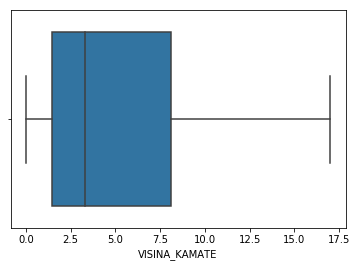

In [69]:
seaborn.boxplot(druga_faza['VISINA_KAMATE'].astype(float))

In [27]:
druga_faza['VISINA_KAMATE'] = druga_faza['VISINA_KAMATE'].replace(72, np.nan)

In [28]:
druga_faza.to_csv('treca_faza.csv')